## Explore the Data

In [1]:
import os
from os import listdir
from keras.preprocessing import image
import numpy as np
import pandas as pd

# get file stats in each subfolder of path
def summarize_stats(path="./"):
    label_classes = os.listdir(path)
    label_counts = dict()
    n_samples = 0
    images_stats = []
    for label_class in label_classes:
        class_path = os.path.join(path, label_class)
        img_names = os.listdir(class_path)
        n_samples_class = len(img_names)
        label_counts.update({label_class:n_samples_class})
        n_samples = n_samples + n_samples_class
        
        for img_name in img_names:
            img_path = os.path.join(class_path, img_name)
            sample = image.load_img(img_path)
            sample_array = image.img_to_array(sample)
            sample_stats = [label_class]
            sample_stats.extend(sample_array.shape[:2])
            sample_stats.extend([np.max(sample_array), np.min(sample_array)])
            images_stats.append(sample_stats)
        
    print("Samples:", n_samples)
    print("Label Counts:", label_counts)
    return (pd.DataFrame
            .from_records(images_stats, 
                  columns=['class', 'width', 'length', 'max_pixel', 'min_pixel'])
            .groupby('class')
            .describe().transpose().unstack(0))

C:\Users\mucun\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
summarize_stats("./dataset/raw_data/")

Samples: 877
Label Counts: {'Acne': 246, 'Rosacea': 255, 'Vitiligo': 376}


class        Acne                                         Rosacea              \
           length   max_pixel   min_pixel       width      length   max_pixel   
count  246.000000  246.000000  246.000000  246.000000  255.000000  255.000000   
mean   292.276423  242.060976    3.117886  221.056911  261.800000  253.149020   
std      4.335522   18.488837    7.792613   16.576995   43.476521    6.628006   
min    292.000000  179.000000    0.000000  220.000000  150.000000  197.000000   
25%    292.000000  234.000000    0.000000  220.000000  225.000000  255.000000   
50%    292.000000  253.000000    0.000000  220.000000  265.000000  255.000000   
75%    292.000000  255.000000    3.000000  220.000000  291.500000  255.000000   
max    360.000000  255.000000   63.000000  480.000000  387.000000  255.000000   

class                            Vitiligo                                      
        min_pixel       width      length   max_pixel   min_pixel       width  
count  255.000000  255.000000  376.000000  376.000000  376.000000  376.000000  
mean     2.329412  197.709804  252.031915  252.561170    1.162234  204.872340  
std      8.378433   34.737062   43.326347    9.657963    4.973826   35.683866  
min      0.000000  130.000000  167.000000  165.000000    0.000000  120.000000  
25%      0.000000  173.000000  225.000000  255.000000    0.000000  183.000000  
50%      0.000000  190.000000  259.000000  255.000000    0.000000  194.000000  
75%      0.000000  225.000000  275.000000  255.000000    0.000000  225.000000  
max     69.000000  311.000000  419.000000  255.000000   45.000000  302.000000

All the pictures are about size: 220 * 300, and pixel scale: 0 - 255

Split raw images into train and test sets. For each class, we are going to select 10% images as the test images

Create folders

In [3]:
cwd = os.getcwd()
raw_dataset_path = os.path.join(cwd, 'dataset', 'raw_data')
img_class_folder = os.listdir(raw_dataset_path)

In [4]:
if not os.path.isdir('./dataset/train'):
    os.mkdir('./dataset/train/')
    for subfolder in img_class_folder:
        os.mkdir('./dataset/train/' + subfolder)

if not os.path.isdir('./dataset/test/'):
    os.mkdir('./dataset/test/')
    for subfolder in img_class_folder:
        os.mkdir('./dataset/test/' + subfolder)

In [5]:
import shutil
import numpy as np

# copy test images
for class_folder in img_class_folder:
    subfolder = os.path.join(raw_dataset_path, class_folder)
    # in each class's folder, find all images
    class_img_file_names = np.array(os.listdir(subfolder))
    n_files = len(class_img_file_names)
    # 10% test images
    n_test = n_files // 10
    np.random.shuffle(class_img_file_names)
    test_file_names = class_img_file_names[:n_test]
    for test_file_name in test_file_names:
        source_path = os.path.join(subfolder, test_file_name)
        destination_path = os.path.join(os.path.dirname(raw_dataset_path), 'test', class_folder)
        shutil.copy(source_path, destination_path)
    
    train_file_names = class_img_file_names[n_test:]
    for train_file_name in train_file_names:
        source_path = os.path.join(subfolder, train_file_name)
        destination_path = os.path.join(os.path.dirname(raw_dataset_path), 'train', class_folder)
        shutil.copy(source_path, destination_path)

Train and Test data information

In [6]:
print("train raw images")
stats = summarize_stats(os.path.join(os.path.dirname(raw_dataset_path), 'train'))
print("test raw images")
stats = summarize_stats(os.path.join(os.path.dirname(raw_dataset_path), 'test'))

train raw images
Samples: 791
Label Counts: {'Acne': 222, 'Rosacea': 230, 'Vitiligo': 339}
test raw images
Samples: 86
Label Counts: {'Acne': 24, 'Rosacea': 25, 'Vitiligo': 37}


Raw image examples

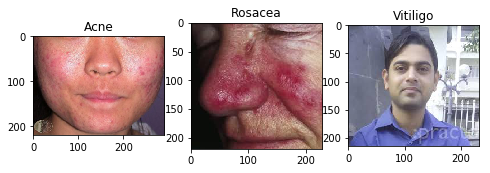

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 3, figsize=(8,6))

for i, class_path in enumerate(os.listdir(raw_dataset_path)):
#     sample_number = 150
    sample_number = np.random.randint(200)
    sample_name = os.listdir(os.path.join(raw_dataset_path, class_path))[sample_number]
    sample_path = os.path.join(raw_dataset_path, class_path, sample_name)
    sample = mpimg.imread(sample_path)
    axarr[i].imshow(sample)
    axarr[i].set_title(class_path)
plt.show()

In order to increase our data size and make the model robust, we are going to do some data augmentation.
- normalization
- shear angle
- zoom range
- rotation
- horizontal flip

In [9]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 45,
                                   horizontal_flip = True)

In [10]:
# define a function to show the difference between the original image and augmentation image
def display_image_augmentation(img_data_gen, img_path):
    f, axarr = plt.subplots(1, 2, figsize=(8, 6))
    original_img = image.load_img(img_path)
    axarr[0].imshow(original_img)
    axarr[0].set_title('original')
    
    resized_img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(resized_img)
    img_array = np.expand_dims(img_array, axis=0)
    img_augmented = img_data_gen.flow(img_array)
    axarr[1].imshow(np.squeeze(img_augmented[0]))
    axarr[1].set_title('augmentation')
    plt.show()    

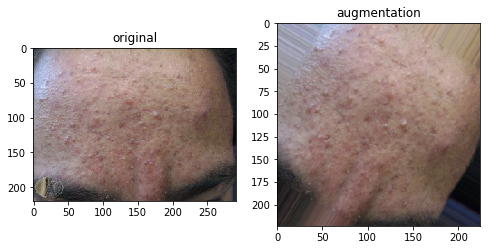

In [11]:
sample_number = np.random.randint(200)
sample_name = os.listdir(os.path.join(raw_dataset_path, 'Acne'))[sample_number]
sample_path = os.path.join(raw_dataset_path, 'Acne', sample_name)
display_image_augmentation(img_gen, sample_path)

### Check Point

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_img_gen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 45,
                                   horizontal_flip = True)
test_img_gen = ImageDataGenerator(rescale = 1./255)

train = train_img_gen.flow_from_directory('dataset/train',
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical')
# validation = train_img_gen.flow_from_directory('dataset/train',
#                                                target_size = (224, 224),
#                                                batch_size = 32,
#                                                class_mode = 'categorical',
#                                                subset = 'validation')

test = test_img_gen.flow_from_directory('dataset/test',
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 791 images belonging to 3 classes.
Found 86 images belonging to 3 classes.


### Baseline Models

5 layers NN

In [46]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD

model = Sequential()

model.add(Flatten(input_shape=(224, 224, 3)))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=3, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.fit_generator(train,
                    steps_per_epoch=100,
                    epochs=25,
                    validation_data=validation,
                    validation_steps=100)

Epoch 1/25
100/100 [==============================] - 83s 826ms/step - loss: 1.2486 - acc: 0.4112 - val_loss: 1.0815 - val_acc: 0.4229
Epoch 2/25
100/100 [==============================] - 78s 781ms/step - loss: 1.0795 - acc: 0.4288 - val_loss: 1.0817 - val_acc: 0.4217
Epoch 3/25
100/100 [==============================] - 80s 799ms/step - loss: 1.0796 - acc: 0.4279 - val_loss: 1.0816 - val_acc: 0.4217
Epoch 4/25
100/100 [==============================] - 77s 773ms/step - loss: 1.0825 - acc: 0.4267 - val_loss: 1.0813 - val_acc: 0.4225
Epoch 5/25
100/100 [==============================] - 78s 780ms/step - loss: 1.0803 - acc: 0.4272 - val_loss: 1.0811 - val_acc: 0.4229
Epoch 6/25
100/100 [==============================] - 80s 804ms/step - loss: 1.0798 - acc: 0.4274 - val_loss: 1.0809 - val_acc: 0.4233
Epoch 7/25
100/100 [==============================] - 78s 782ms/step - loss: 1.0785 - acc: 0.4314 - val_loss: 1.0807 - val_acc: 0.4240
Epoch 8/25
100/100 [==============================] - 7

In [47]:
score = model.evaluate_generator(test)
print(score)

[1.0782018068224886, 0.4302325616049212]


In [48]:
model.save_weights('dnn.h5')

In [8]:
from keras.models import Sequential
from keras.layers import Cuse_multiprocessingonv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.fit_generator(train,
                    epochs=25,
                    validation_data=test,
                    use_multiprocessing=True)

Epoch 1/25
25/25 [==============================] - 155s 6s/step - loss: 1.1141 - acc: 0.4011 - val_loss: 1.0371 - val_acc: 0.4302
Epoch 2/25
25/25 [==============================] - 159s 6s/step - loss: 0.9948 - acc: 0.5115 - val_loss: 1.0441 - val_acc: 0.4302
Epoch 3/25
25/25 [==============================] - 151s 6s/step - loss: 0.9883 - acc: 0.4918 - val_loss: 1.0235 - val_acc: 0.4419
Epoch 4/25
25/25 [==============================] - 157s 6s/step - loss: 0.9246 - acc: 0.5679 - val_loss: 0.9051 - val_acc: 0.6279
Epoch 5/25
25/25 [==============================] - 152s 6s/step - loss: 0.8465 - acc: 0.6290 - val_loss: 0.8117 - val_acc: 0.6279
Epoch 6/25
25/25 [==============================] - 150s 6s/step - loss: 0.8348 - acc: 0.6364 - val_loss: 0.7900 - val_acc: 0.6628
Epoch 7/25
25/25 [==============================] - 149s 6s/step - loss: 0.8071 - acc: 0.6394 - val_loss: 0.6945 - val_acc: 0.6860
Epoch 8/25
25/25 [==============================] - 150s 6s/step - loss: 0.7490 - a

In [9]:
score = model.evaluate_generator(test)
print(score)

[0.52849095505337385, 0.75581395487452663]


In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=False, weights='imagenet')

C:\Users\mucun\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


58892288/58889256 [==============================] - 29s 1us/step


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.models import Model

In [42]:
from keras.preprocessing.image import ImageDataGenerator

train_img_gen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 45,
                                   horizontal_flip = True)
test_img_gen = ImageDataGenerator(rescale = 1./255)

train = train_img_gen.flow_from_directory('dataset/train',
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical',
                                          seed=11,
                                          shuffle=False)
# validation = train_img_gen.flow_from_directory('dataset/train',
#                                                target_size = (224, 224),
#                                                batch_size = 32,
#                                                class_mode = 'categorical',
#                                                subset = 'validation')

test = test_img_gen.flow_from_directory('dataset/test',
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        seed=11,
                                        shuffle=False)

Found 791 images belonging to 3 classes.
Found 86 images belonging to 3 classes.


In [43]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# top_model_weights_path = 'bottleneck_fc_model.h5'
# train_data_dir = 'data/train'
# validation_data_dir = 'data/validation'

model = applications.VGG16(include_top=False, weights='imagenet')

pre_train_model = model.predict_generator(train, len(train))
# np.save(open('pre_train_model.npy', 'w'), pre_train_model)

pre_validation_model = model.predict_generator(test, len(test))
# np.save(open('pre_validation_model.npy', 'w'), pre_validation_model)

In [60]:
train_list = [[1, 0, 0]] * 222
train_list.extend([[0, 1, 0]] * 230)
train_list.extend([[0, 0, 1]] * 339)
test_list = [[1, 0, 0]] * 24
test_list.extend([[0, 1, 0]] * 25)
test_list.extend([[0, 0, 1]] * 37)

In [61]:
train_labels = np.array(train_list)
test_labels = np.array(test_list)

In [37]:
train_labels = []
for i in range(len(train)):
    train_labels.append(train[i][1])
train_labels = np.vstack(train_labels)

test_labels = []
for i in range(len(test)):
    test_labels.append(test[i][1])
test_labels = np.vstack(test_labels)

In [64]:
# train_data = np.load(open('pre_train_model.npy'))

# validation_data = np.load(open('pre_validation_model.npy'))

model = Sequential()
model.add(Flatten(input_shape=pre_train_model.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(pre_train_model, train_labels,
          batch_size=32,
          epochs=25,
          validation_data=(pre_validation_model, test_labels))

Train on 791 samples, validate on 86 samples
Epoch 1/25
791/791 [==============================] - 4s 5ms/step - loss: 1.1710 - acc: 0.3009 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 2/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 3/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 4/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 5/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 6/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 7/25
791/791 [==============================] - 1s 2ms/step - loss: 1.0986 - acc: 0.2807 - val_loss: 1.0986 - val_acc: 0.2791
Epoch 8/25
791/791 [===========

In [68]:
score = model.evaluate(pre_validation_model, test_labels)
print(score)

86/86 [==============================] - 0s 547us/step
[1.0986123085021973, 0.27906976744186046]
